In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter
from scipy.stats import uniform


from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest



In [42]:
df=pd.read_csv('/Users/Abdul/Desktop/MMA/Enterprise Data Science/final_df.csv')
df.head()

/var/folders/rj/g3r71fsx2vnbbbjb9v368gr00000gp/T/ipykernel_8560/2924011506.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/Users/Abdul/Desktop/MMA/Enterprise Data Science/final_df.csv')


,fullVisitorId,FirstChannelVisit,LastChannelVisit,at_least_one_conversion,country,continent,subContinent,TotalVisits,TotalBounces,Organic Search,...,Display,(Other),TotalPageviews,desktop,mobile,tablet,FirstSessionPageviews,LastSessionPageviews,Conversion,CampaignVisits
0,4823595352351,Organic Search,Organic Search,0,China,Asia,Eastern Asia,1,1,1,...,0,0,1,1,0,0,1,1,0,0
1,5103959234087,Organic Search,Organic Search,0,United States,Americas,Northern America,1,0,1,...,0,0,8,0,1,0,8,8,0,0
2,10278554503158,Organic Search,Organic Search,0,New Zealand,Oceania,Australasia,1,0,1,...,0,0,8,1,0,0,8,8,0,0
3,20424342248747,Organic Search,Organic Search,0,Peru,Americas,South America,1,0,1,...,0,0,13,1,0,0,13,13,0,0
4,26722803385797,Organic Search,Organic Search,0,United Kingdom,Europe,Northern Europe,1,0,1,...,0,0,2,1,0,0,2,2,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723803 entries, 0 to 723802
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   fullVisitorId            723803 non-null  object
 1   FirstChannelVisit        723803 non-null  object
 2   LastChannelVisit         723803 non-null  object
 3   at_least_one_conversion  723803 non-null  int64 
 4   country                  723803 non-null  object
 5   continent                723803 non-null  object
 6   subContinent             723803 non-null  object
 7   TotalVisits              723803 non-null  int64 
 8   TotalBounces             723803 non-null  int64 
 9   Organic Search           723803 non-null  int64 
 10  Social                   723803 non-null  int64 
 11  Direct                   723803 non-null  int64 
 12  Paid Search              723803 non-null  int64 
 13  Referral                 723803 non-null  int64 
 14  Affiliates          

In [95]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
at_least_one_conversion,723803.0,0.013973,0.117380,0.0,0.0,0.0,0.0,1.0
TotalBounces,723803.0,0.622587,0.892970,0.0,0.0,1.0,1.0,171.0
Organic Search,723803.0,0.527161,0.982620,0.0,0.0,0.0,1.0,243.0
Social,723803.0,0.312401,0.593423,0.0,0.0,0.0,1.0,141.0
Direct,723803.0,0.197603,0.742847,0.0,0.0,0.0,0.0,152.0
Paid Search,723803.0,0.034990,0.323373,0.0,0.0,0.0,0.0,118.0
Referral,723803.0,0.144843,0.662433,0.0,0.0,0.0,0.0,104.0
Affiliates,723803.0,0.022662,0.203802,0.0,0.0,0.0,0.0,38.0
Display,723803.0,0.008652,0.193096,0.0,0.0,0.0,0.0,89.0
(Other),723803.0,0.000166,0.016030,0.0,0.0,0.0,0.0,4.0


In [4]:
df.columns

Index(['fullVisitorId', 'FirstChannelVisit', 'LastChannelVisit',
       'at_least_one_conversion', 'country', 'continent', 'subContinent',
       'TotalVisits', 'TotalBounces', 'Organic Search', 'Social', 'Direct',
       'Paid Search', 'Referral', 'Affiliates', 'Display', '(Other)',
       'TotalPageviews', 'desktop', 'mobile', 'tablet',
       'FirstSessionPageviews', 'LastSessionPageviews', 'Conversion',
       'CampaignVisits'],
      dtype='object')

In [43]:
df.drop(['Conversion','fullVisitorId','country'],axis=1,inplace=True)

at_least_one_conversion
0    0.986027
1    0.013973
Name: proportion, dtype: float64


/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


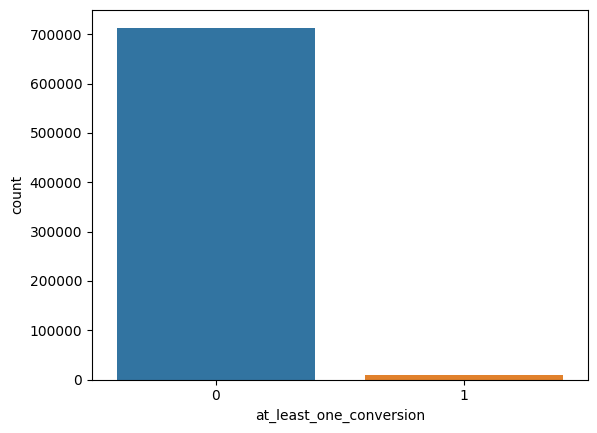

In [6]:
# Checking the class distribution of the target variable
print(df['at_least_one_conversion'].value_counts(normalize=True))
sns.countplot(x=df['at_least_one_conversion']);

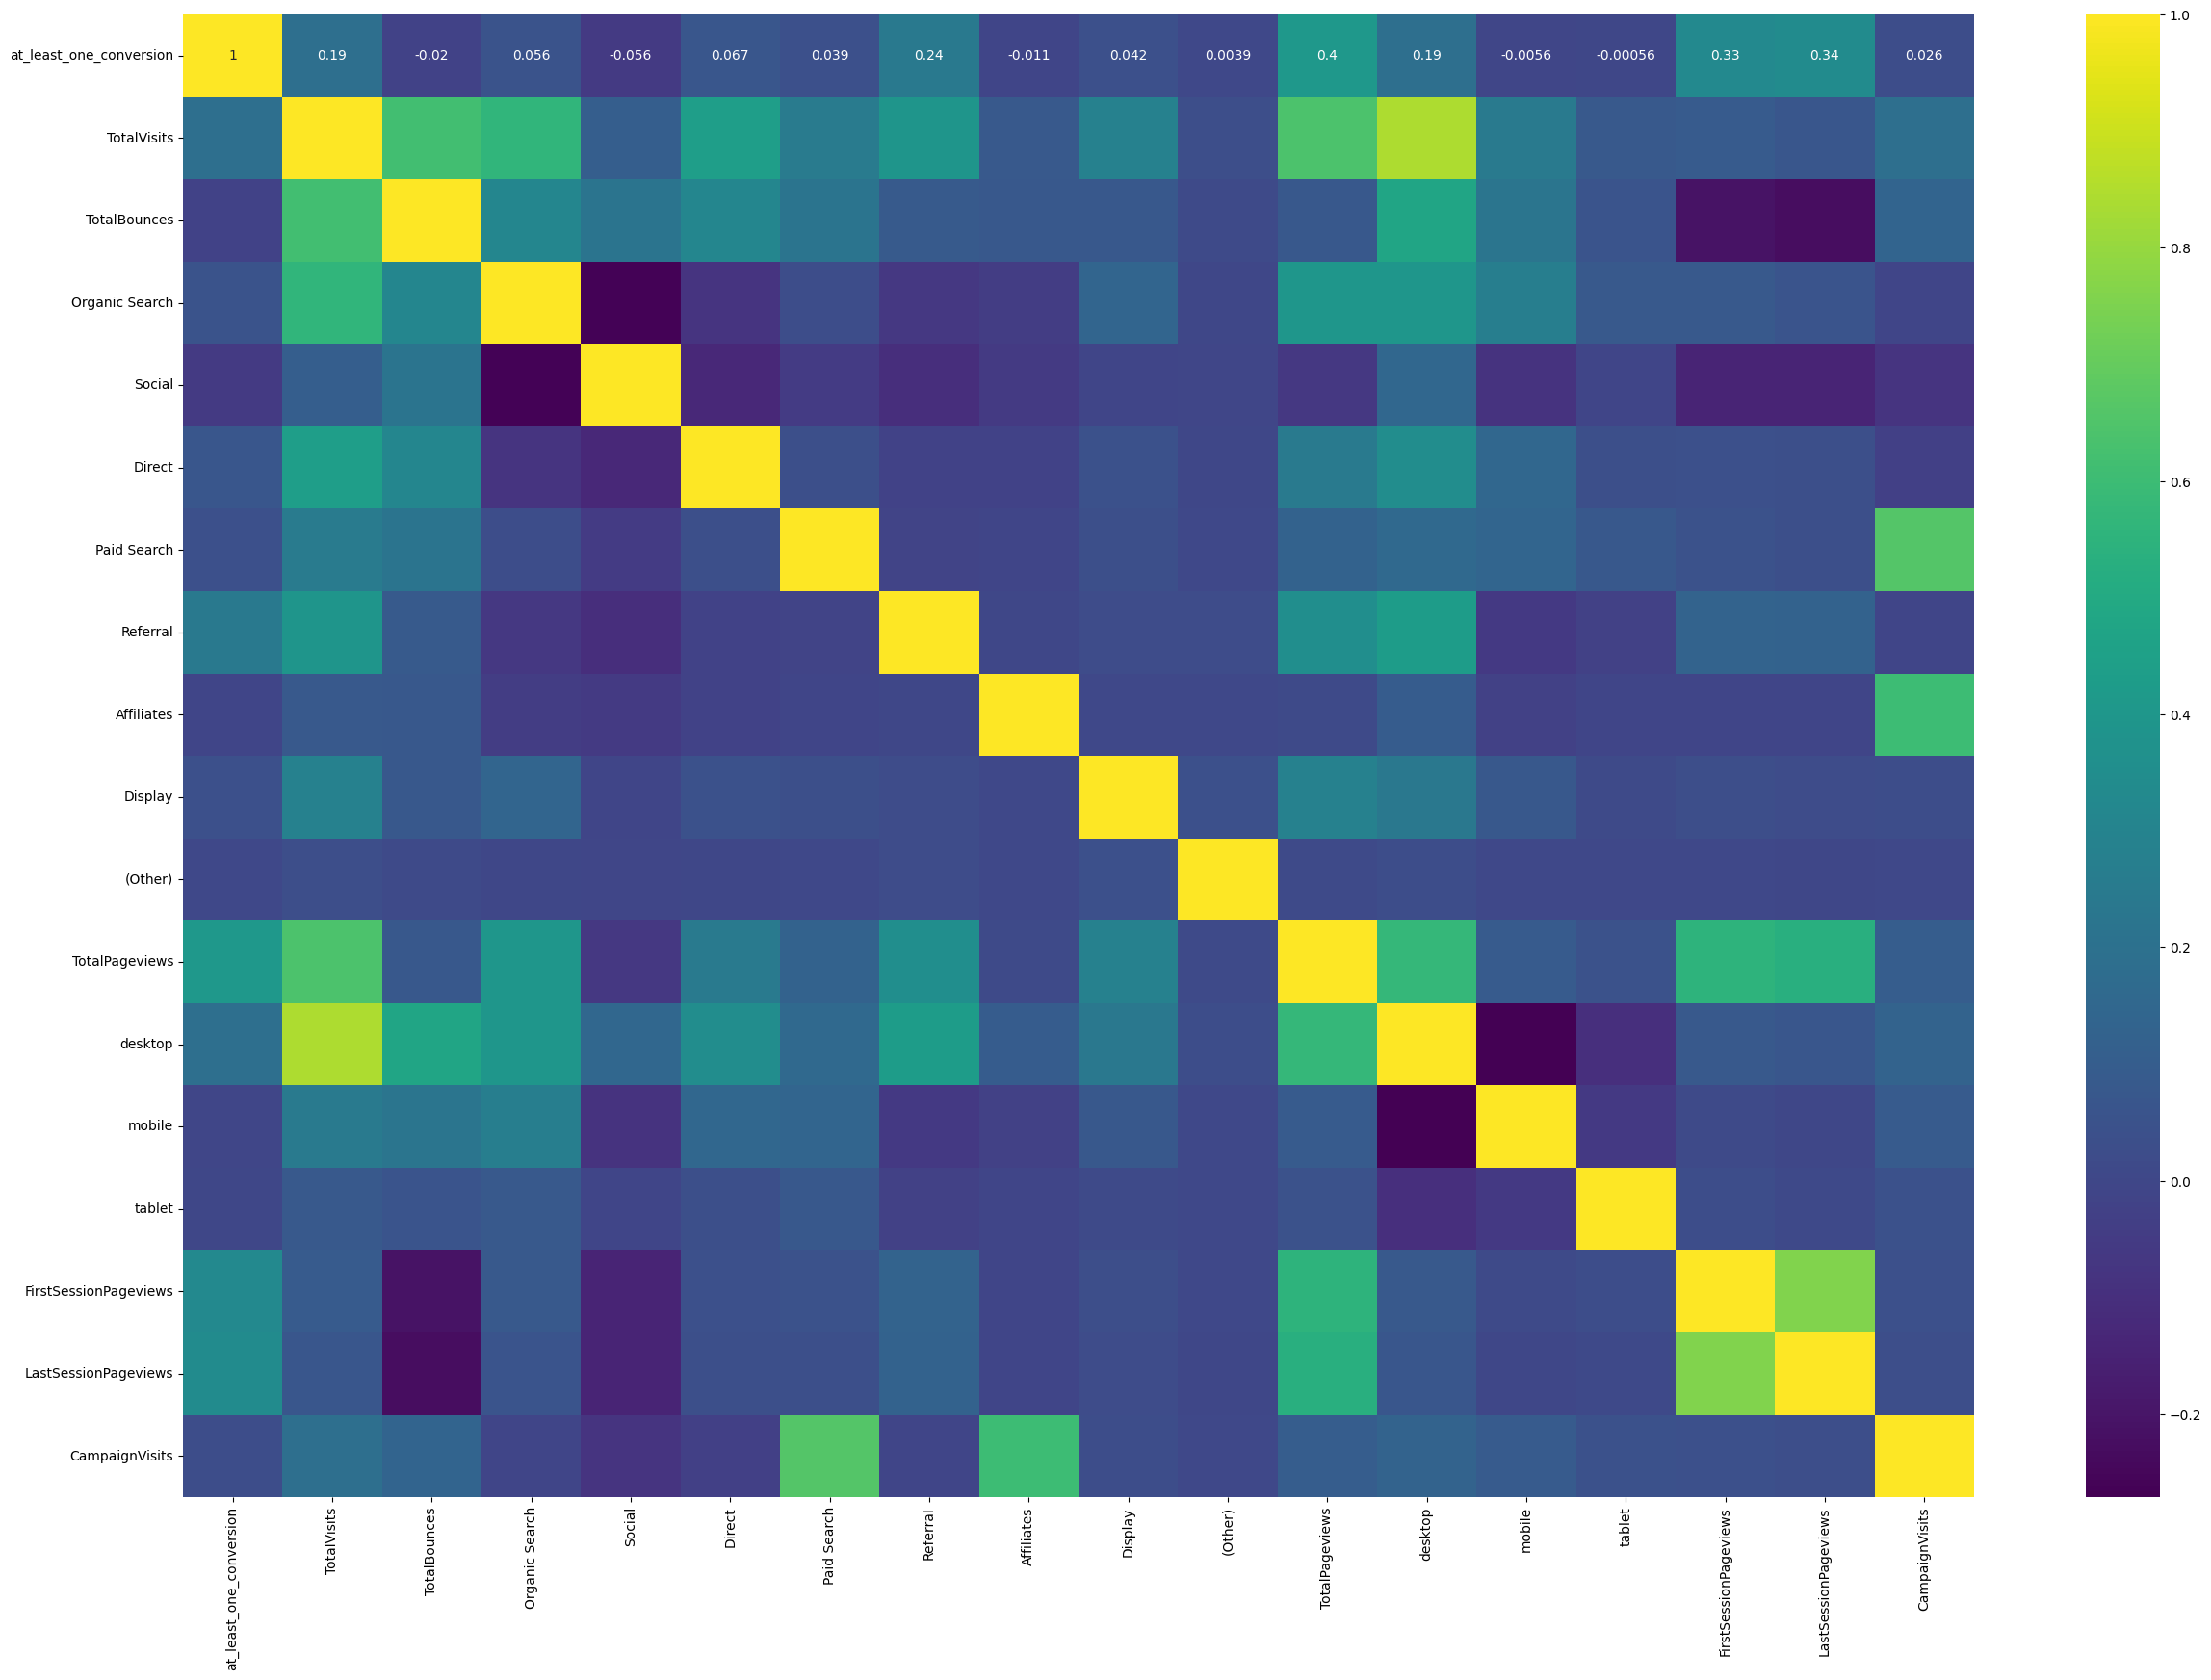

In [54]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(30,20))
sns.heatmap(numeric_df.corr(),annot=True,cmap='viridis');

In [58]:
#numeric_df.corr()

# correlation gretaer than 0.5
correlation = numeric_df.corr()
correlation = correlation.abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation > 0.4]
correlation = correlation[correlation < 1]
correlation = pd.DataFrame(correlation).reset_index()
correlation.columns = ['feature1', 'feature2', 'correlation']

correlation



,feature1,feature2,correlation
0,TotalVisits,desktop,0.843122
1,desktop,TotalVisits,0.843122
2,FirstSessionPageviews,LastSessionPageviews,0.759976
3,LastSessionPageviews,FirstSessionPageviews,0.759976
4,CampaignVisits,Paid Search,0.661457
5,Paid Search,CampaignVisits,0.661457
6,TotalPageviews,TotalVisits,0.641759
7,TotalVisits,TotalPageviews,0.641759
8,TotalVisits,TotalBounces,0.614978
9,TotalBounces,TotalVisits,0.614978


In [60]:
df.drop(['TotalVisits','LastSessionPageviews'],axis=1,inplace=True)

In [61]:
cat_cols = df.select_dtypes(include='object').columns

df=pd.get_dummies(df,columns=cat_cols,drop_first=True, dtype='int64')

In [62]:
df.shape

(723803, 57)

### Checking Outliers with Isolation Forest
- Many positive instances (minority class) were identified as outliers
- Will hold off on removing outliers in the interim

In [73]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df)
outlier_pred


array([1, 1, 1, ..., 1, 1, 1])

In [75]:
# Removing the outlierrs.
print("Number of rows without outliers:", len(df[outlier_pred == 1]))
df_inliers = df.iloc[outlier_pred == 1]

print("New shape:", df.shape)
df_inliers.at_least_one_conversion.value_counts(normalize=True)


Number of rows without outliers: 703920
New shape: (723803, 57)


at_least_one_conversion
0    0.991361
1    0.008639
Name: proportion, dtype: float64

In [76]:
X=df.drop('at_least_one_conversion',axis=1)
y=df['at_least_one_conversion']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [78]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [79]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [85]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
        plt.show()
        print("End of validation Result\n")


### Baseline Model

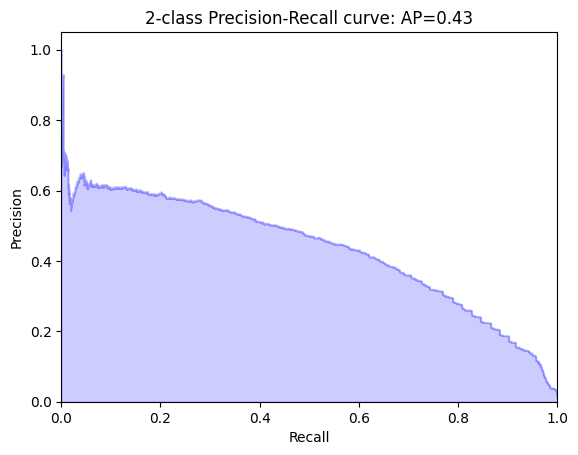

roc auc score: 0.9757701958423538



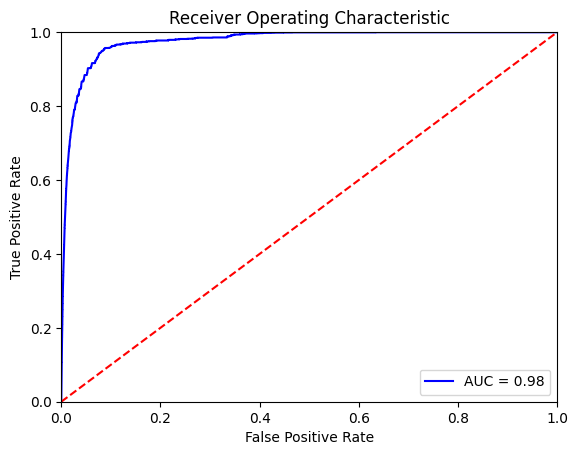

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    214230
           1       0.57      0.24      0.34      2911

    accuracy                           0.99    217141
   macro avg       0.78      0.62      0.67    217141
weighted avg       0.98      0.99      0.98    217141


Confusion Matrix: 
 [[213706    524]
 [  2205    706]]



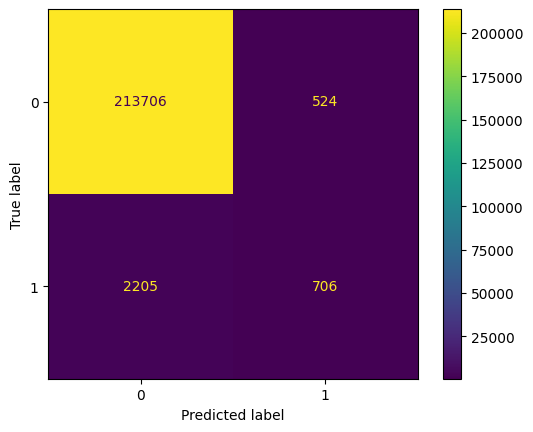

End of validation Result



In [86]:
logreg=LogisticRegression(max_iter=10000,random_state=42)
logreg.fit(X_train, y_train)
clf_score(logreg, X_train, y_train, X_test, y_test, train=False)

# Setting Class weight to balanced

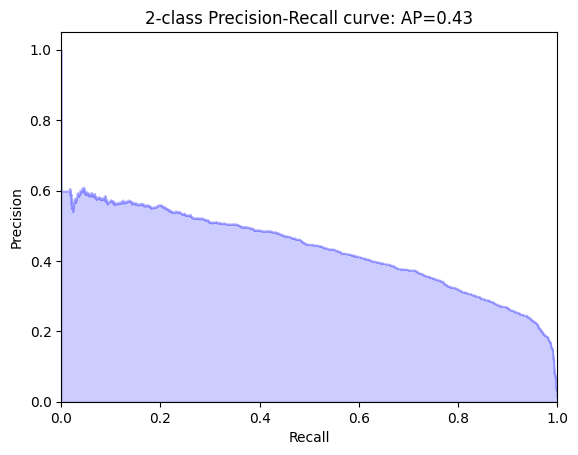

roc auc score: 0.9852216216087935



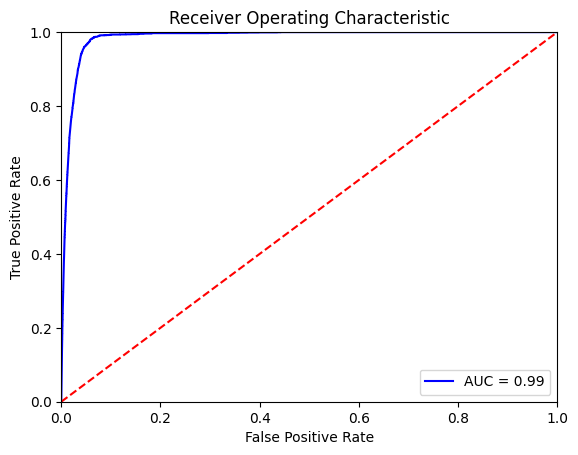

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    214230
           1       0.21      0.96      0.34      2911

    accuracy                           0.95    217141
   macro avg       0.60      0.96      0.66    217141
weighted avg       0.99      0.95      0.97    217141


Confusion Matrix: 
 [[203530  10700]
 [   103   2808]]



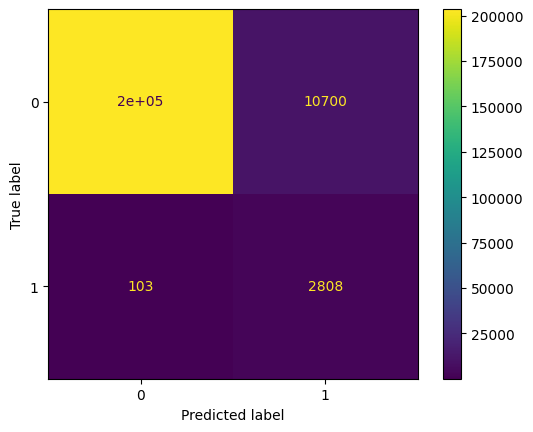

End of validation Result



In [87]:
logreg2=LogisticRegression(max_iter=10000, class_weight='balanced',random_state=42)
logreg2.fit(X_train, y_train)
clf_score(logreg2, X_train, y_train, X_test, y_test, train=False)


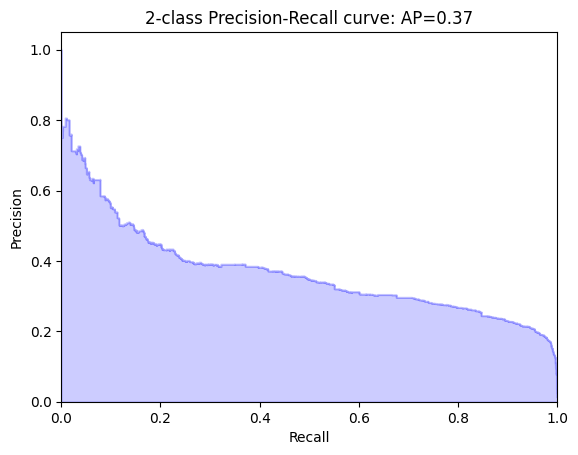

roc auc score: 0.98194475599726



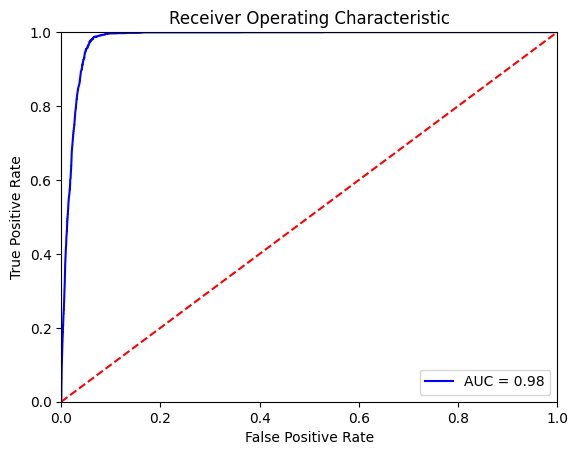

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    214230
           1       0.17      0.98      0.29      2911

    accuracy                           0.94    217141
   macro avg       0.59      0.96      0.63    217141
weighted avg       0.99      0.94      0.96    217141


Confusion Matrix: 
 [[200501  13729]
 [    46   2865]]



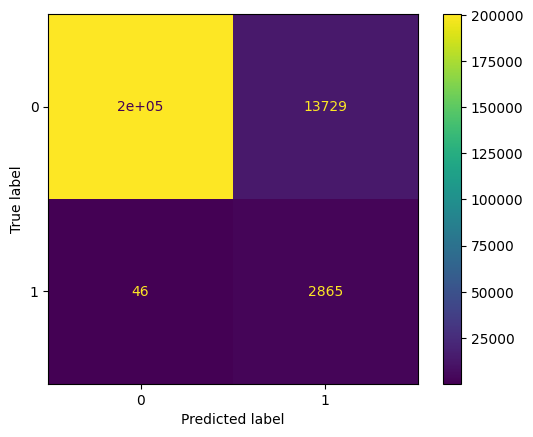

End of validation Result



In [88]:
rf_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
clf_score(rf_model, X_train, y_train, X_test, y_test, train=False)

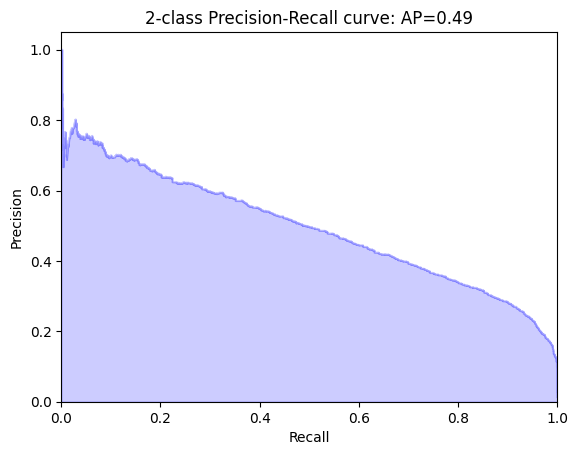

roc auc score: 0.9873156197297431



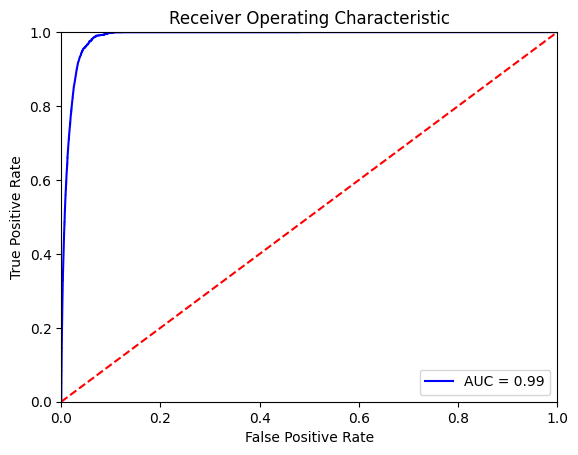

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    214230
           1       0.20      0.96      0.33      2911

    accuracy                           0.95    217141
   macro avg       0.60      0.96      0.65    217141
weighted avg       0.99      0.95      0.96    217141


Confusion Matrix: 
 [[203103  11127]
 [   102   2809]]



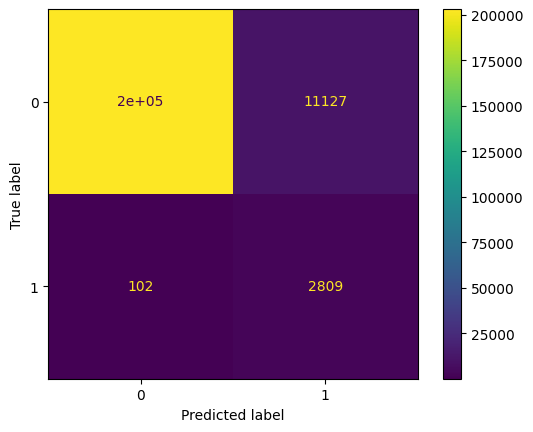

End of validation Result



In [89]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model=xgboost.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
clf_score(xgb_model, X_train, y_train, X_test, y_test, train=False)

### Feature Selection Using Random Forest and RFE

In [90]:
# getting the feature importance from the random forest model   
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
TotalPageviews,0.363753
FirstSessionPageviews,0.150012
subContinent_Northern America,0.109214
desktop,0.068609
continent_Americas,0.056066


/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Abdul/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Feature Importance')

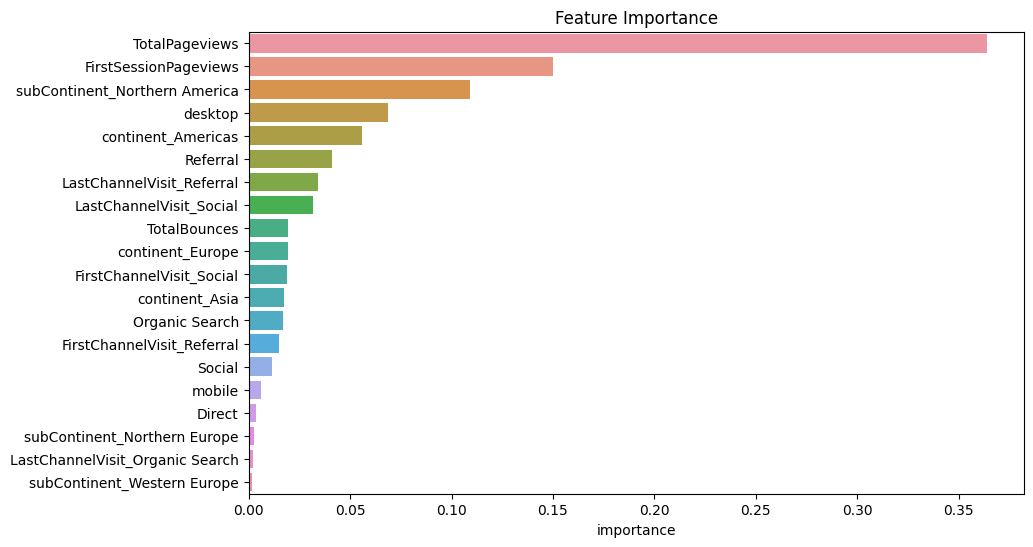

In [91]:
#plotting the top 20 features
plt.figure(figsize=(10, 6)) 
sns.barplot(x=feature_importances['importance'][:20], y=feature_importances.index[:20])
plt.title('Feature Importance')


In [96]:
# Using the top 20 features from the random forest model
top_features = feature_importances.index[:20]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


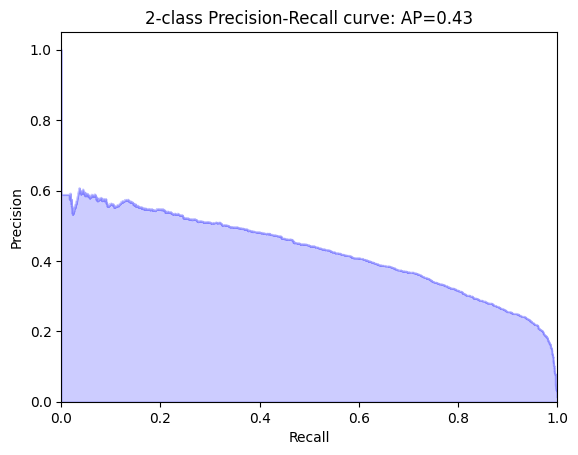

roc auc score: 0.9848308586111238



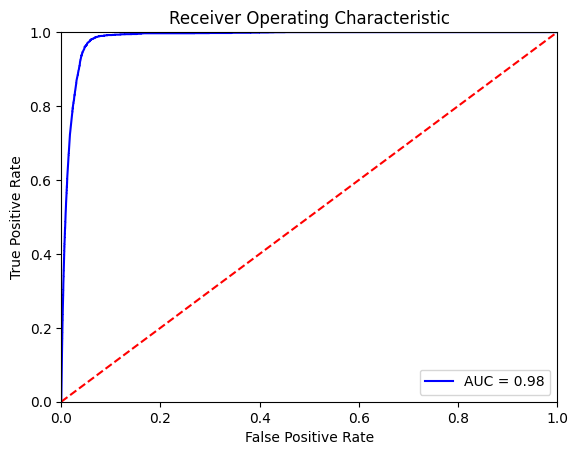

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    214230
           1       0.21      0.97      0.34      2911

    accuracy                           0.95    217141
   macro avg       0.60      0.96      0.66    217141
weighted avg       0.99      0.95      0.97    217141


Confusion Matrix: 
 [[203339  10891]
 [   101   2810]]



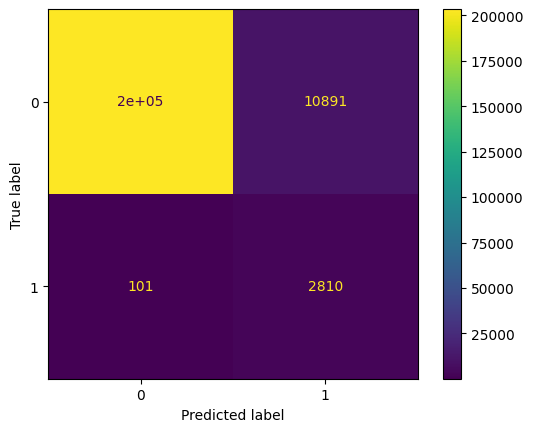

End of validation Result



In [98]:
logreg3=LogisticRegression(max_iter=10000,random_state=42, class_weight='balanced')
logreg3.fit(X_train_top, y_train)
clf_score(logreg3, X_train_top, y_train, X_test_top, y_test, train=False)

### Logistic Regression with Inliers
- Worse performance given more pronounced class imbalance

In [99]:
X_inlier=df_inliers.drop('at_least_one_conversion',axis=1)
y_inlier=df_inliers['at_least_one_conversion']

In [100]:
X_train_inlier, X_test_inlier, y_train_inlier, y_test_inlier = train_test_split(X_inlier, y_inlier, test_size=0.30, random_state=42)

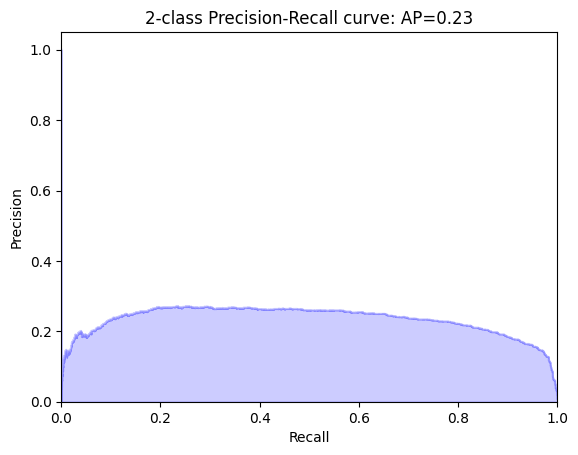

roc auc score: 0.9834985257490613



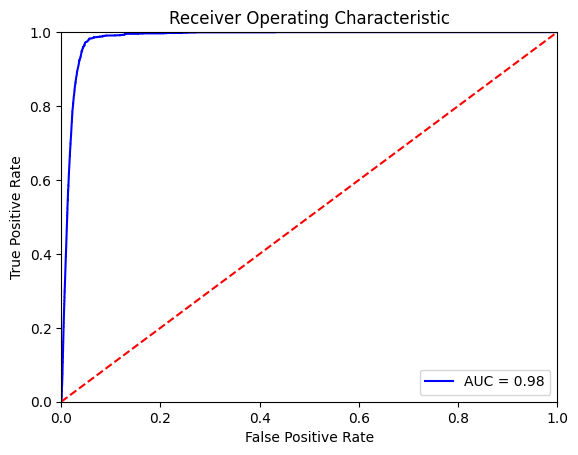

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    209425
           1       0.13      0.98      0.24      1751

    accuracy                           0.95    211176
   macro avg       0.57      0.96      0.60    211176
weighted avg       0.99      0.95      0.97    211176


Confusion Matrix: 
 [[198376  11049]
 [    43   1708]]



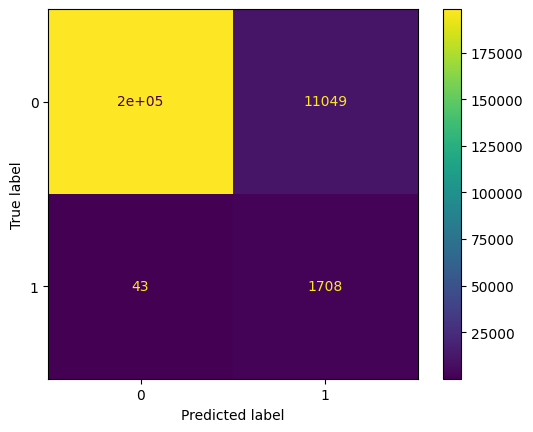

End of validation Result



In [101]:
logreg4=LogisticRegression(max_iter=10000,random_state=42, class_weight='balanced')
logreg4.fit(X_train_inlier, y_train_inlier)
clf_score(logreg4, X_train_inlier, y_train_inlier, X_test_inlier, y_test_inlier, train=False)

In [102]:
param_distributions = {
    'C': uniform(0.01, 10),  
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'l1_ratio': uniform(0, 1)  
}

random_search = RandomizedSearchCV(
    estimator=logreg3,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='f1',  
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_top, y_train)

print("Best hyperparameters: ", random_search.best_params_)


clf_score(random_search.best_estimator_, X_train_top, y_train, X_test_top, y_test, train=False)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
def find_optimal_threshold(clf, X_val, y_val):
    probas_val = clf.predict_proba(X_val)[:, 1]
    
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in np.arange(0.01, 1, 0.01):
        predictions = (probas_val >= threshold).astype(int)
        
        f1 = f1_score(y_val, predictions)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold, best_f1


In [ ]:

def clf_score_th(clf, X_train, y_train, X_val, y_val, train=True, threshold=0.5):  
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")
    else:
        probas_val = clf.predict_proba(X_val)[:, 1]
        predictions_val = (probas_val >= threshold).astype(int) 

        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val, response_method="predict_proba")
        plt.show()
        print("End of validation Result\n")

In [ ]:
optimal_threshold, optimal_f1 = find_optimal_threshold(random_search.best_estimator_, X_test_top, y_test)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1 Score: {optimal_f1:.4f}")


In [ ]:
clf_score_th(random_search.best_estimator_, X_train_top, y_train, X_test_top, y_test, train=False, threshold=optimal_threshold)

## Printing Coefficients for the logistic regression model

In [ ]:
random_search.best_estimator_.coef_
Results=pd.DataFrame(random_search.best_estimator_.coef_, columns=X_train_top.columns)
Results
